### General setup

In [1]:
%matplotlib widget

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz

In [3]:
import pandas as pd
from random import shuffle

In [4]:
import tensorflow as tf
from object_detection.utils import dataset_util

In [5]:
from PIL import Image

In [6]:
import io

Set download location

In [7]:
import pathlib
datasets_path = pathlib.Path().resolve() / "raw_datasets"
fo.config.dataset_zoo_dir = datasets_path

List avaialble datasets

In [8]:
fo.list_datasets()

['2022.10.18.22.25.47',
 '2022.10.18.22.36.00',
 '2022.10.19.10.57.45',
 'bdd100k-test',
 'bdd100k-train',
 'bdd100k-validation',
 'bdd_test_6000',
 'bdd_train_6000',
 'bdd_validation_6000',
 'coco-2017-test-2400',
 'coco-2017-train-12000',
 'coco-2017-validation-2400',
 'kitti-test',
 'kitti-train',
 'kitti_test_6000',
 'kitti_train_6000',
 'kitti_validation_6000']

## Raw dataset preparation

If Raw datasets already preapred "Raw dataset preparation" can be skipped - move to "TF Record CReation"

### KITTI Dataset

#### Training and Validation

In [218]:
kitti_train = foz.load_zoo_dataset("kitti", split="train")

Split 'train' already downloaded
Loading existing dataset 'kitti-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Extract 20% from training set for validation

In [219]:
index = int(len(kitti_train) * 0.8)
kitti_train_view = kitti_train.shuffle()[:index]
kitti_validation_view = kitti_train.shuffle()[index:]

Check if all images are used and none is duplicated (due to rounding of index)

In [220]:
len(kitti_train_view) + len(kitti_validation_view) == len(kitti_train)

True

In [221]:
kitti_train_6000 = fo.Dataset()
kitti_train_6000.merge_samples(kitti_train_view)
kitti_train_6000.name = 'kitti_train_6000'

ValueError: A dataset with name 'kitti_train_6000' already exists

In [222]:
kitti_validation_6000 = fo.Dataset()
kitti_validation_6000.merge_samples(kitti_validation_view)
kitti_validation_6000.name = 'kitti_validation_6000'

#### Test

In [8]:
kitti_test = foz.load_zoo_dataset("kitti", split="test")

Parsing dataset metadata
Found 7518 samples
Dataset info written to 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\kitti\info.json'
Loading 'kitti' split 'test'
 100% |███████████████| 7518/7518 [4.4m elapsed, 0s remaining, 27.7 samples/s]      
Dataset 'kitti-test' created


Take only 1200 samples from test split

In [9]:
kitti_test_view = kitti_test.view()
kitti_test_view = kitti_test_view.shuffle()[:1200]

Save as a new dataset

In [11]:
kitti_test_6000 = fo.Dataset()
kitti_test_6000.merge_samples(kitti_test_view)
kitti_test_6000.name = 'kitti_test_6000'

### COCO Dataset

In [12]:
def download_coco(split, max_samples):
    # Restarting download after connection timeout
    try:
        coco_train = fo.zoo.load_zoo_dataset("coco-2017", split=split, label_types=["detections"], classes=["person", "bicycle", "car", "motorcycle", "bus", "train", "truck", 
        "traffic light", "fire hydrant", "parking meter", "bench", "cat", "dog", "chair", "couch", "bed", "dining table", "tv", "laptop"], only_matching=True, max_samples=max_samples)
    except:
        coco_train = download_coco(split, max_samples)

    return coco_train

In [50]:
coco_train = download_coco('train', 12000)

Found annotations at 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\raw\instances_train2017.json'
11798 images found; downloading the remaining 202
 100% |██████████████████| 202/202 [22.0s elapsed, 0s remaining, 10.0 images/s]     
Writing annotations for 12000 downloaded samples to 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\train\labels.json'
Dataset info written to 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\info.json'
Loading 'coco-2017' split 'train'
 100% |█████████████| 12000/12000 [44.4s elapsed, 0s remaining, 228.1 samples/s]      
Dataset 'coco-2017-train-12000' created


In [217]:
coco_validation = download_coco('validation', 2400)

Found annotations at 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\raw\instances_val2017.json'
300 images found; downloading the remaining 2100
  43% |██████\---------|  907/2100 [2.0m elapsed, 2.4m remaining, 9.2 images/s]     
Found annotations at 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\raw\instances_val2017.json'
1207 images found; downloading the remaining 1193
   0% ||---------------|    0/1193 [21.1s elapsed, ? remaining, ? images/s] 
Found annotations at 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\raw\instances_val2017.json'
1207 images found; downloading the remaining 1193
   0% ||---------------|    0/1193 [21.2s elapsed, ? remaining, ? images/s] 
Found annotations at 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\raw\instances_val2017.json'
1207 images found; downloading the remaining 1193
   0% |----------------|  

In [14]:
coco_test = download_coco('test', 2400)

Test split is unlabeled; ignoring classes requirement
Found test info at 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\raw\image_info_test2017.json'
Sufficient images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'coco-2017-test-2400'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### BDD Dataset

#### Training

In [4]:
bdd_train = foz.load_zoo_dataset(
    "bdd100k",
    split="train",
    source_dir=r'raw_datasets/bdd100k/',
)

Preparing split 'train' in 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\bdd100k\train'
Preparing training images...
Preparing training labels...
Preparing validation images...
Preparing validation labels...
Preparing test images...
Parsing dataset metadata
Found 70000 samples
Dataset info written to 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\bdd100k\info.json'
Loading 'bdd100k' split 'train'
 100% |█████████████| 70000/70000 [1.0h elapsed, 0s remaining, 42.3 samples/s]      
Dataset 'bdd100k-train' created


Take only 6000 images from shuffled dataset

In [17]:
bdd_train_view = bdd_train.view()
bdd_train_view = bdd_train_view.shuffle()[:6000]

Save view as a new dataset

In [46]:
bdd_train_6000 = fo.Dataset()
bdd_train_6000.merge_samples(bdd_train_view)
bdd_train_6000.name = 'bdd_train_6000'

#### Validation

In [14]:
bdd_validation = foz.load_zoo_dataset(
    "bdd100k",
    split="validation",
    source_dir=r'raw_datasets/bdd100k/',
)

Split 'validation' already prepared
Loading existing dataset 'bdd100k-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Take only 1200 images from shuffled dataset

In [15]:
bdd_validation_view = bdd_validation.view()
bdd_validation_view = bdd_validation_view.shuffle()[:1200]

Save view as a new dataset

In [20]:
bdd_validation_6000 = fo.Dataset()
bdd_validation_6000.merge_samples(bdd_validation_view)
bdd_validation_6000.name = 'bdd_validation_6000'

#### Test

In [15]:
bdd_test = foz.load_zoo_dataset(
    "bdd100k",
    split="test",
    source_dir=r'raw_datasets/bdd100k/',
)

Preparing split 'test' in 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\bdd100k\test'
Parsing dataset metadata
Found 20000 samples
Dataset info written to 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\bdd100k\info.json'
Loading 'bdd100k' split 'test'
 100% |█████████████| 20000/20000 [3.6m elapsed, 0s remaining, 102.2 samples/s]      
Dataset 'bdd100k-test' created


Take only 1200 images from shuffled dataset

In [16]:
bdd_test_view = bdd_test.view()
bdd_test_view = bdd_test_view.shuffle()[:1200]

Save view as new dataset

In [17]:
bdd_test_6000 = fo.Dataset()
bdd_test_6000.merge_samples(bdd_test_view)
bdd_test_6000.name = 'bdd_test_6000'

## Load datasets from disk

No need to run this if "Raw dataset preparation" was run in this session

Train datasets

In [9]:
kitti_train_6000 = fo.load_dataset('kitti_train_6000')
bdd_train_6000 = fo.load_dataset('bdd_train_6000')
coco_train = fo.load_dataset('coco-2017-train-12000')

Validation datasets

In [10]:
kitti_validation_6000 = fo.load_dataset('kitti_validation_6000')
bdd_validation_6000 = fo.load_dataset('bdd_validation_6000')
coco_validation = fo.load_dataset('coco-2017-validation-2400')

Test datasets

In [22]:
kitti_test_6000 = fo.load_dataset('kitti_test_6000')
bdd_test_6000 = fo.load_dataset('bdd_test_6000')
coco_test = fo.load_dataset('coco-2017-test-2400')

In [14]:
fo.launch_app()

Dataset:     -
Session URL: http://localhost:5151/

## TF Record Creation

Need to preproces data only once

### Preprocess data

Delete images without labels and containing only "traffic sign" label from BDD Dataset

In [23]:
def preprocess_bdd(ds):
    dropped_ids = []
    for img in ds:
        if img.detections:
            det_labels = []
            for det in img.detections.detections:
                det_labels.append(det.label)
            det_labels = set(det_labels)
            if len(det_labels) == 1 and "traffic sign" in det_labels:
                dropped_ids.append(img.id)
        else:
            dropped_ids.append(img.id)

    ds.delete_samples(dropped_ids)
    ds.save()

    return ds

In [ ]:
bdd_train_6000 = preprocess_bdd(bdd_train_6000)

In [23]:
bdd_validation_6000 = preprocess_bdd(bdd_validation_6000)

Delete images without labels and with labels containig only "Misc" or "DontCare" from KITTI dataset

In [24]:
def preprocess_kitti(ds):
    correct_labels = ["Car", "Pedestrian", "Van", "Cyclist", "Truck", "Tram", "Person_sitting"]

    dropped_ids = []
    for img in ds:
        det_labels = []
        for det in img.ground_truth.detections:
            det_labels.append(det.label)
        for label in correct_labels:
            if label in det_labels:
                break
            dropped_ids.append(img.id)

    ds.delete_samples(dropped_ids)
    ds.save()

    return ds

In [155]:
kitti_train_6000 = preprocess_kitti(kitti_train_6000)

In [25]:
kitti_validation_6000 = preprocess_kitti(kitti_validation_6000)

### Input datasets statistics

In [11]:
class DatasetStats:
    def __init__(self, bdd, kitti, coco):
        self.bdd_dataset = bdd
        self.kitti_dataset = kitti
        self.coco_dataset = coco

        coco_labels = self.get_gt_labels(coco)
        bdd_labels = self.get_detection_labels(bdd)
        kitti_labels = self.get_gt_labels(kitti)

        self.bdd = pd.DataFrame({"labels": bdd_labels})
        self.coco = pd.DataFrame({"labels": coco_labels})
        self.kitti = pd.DataFrame({"labels": kitti_labels})

    def get_detection_labels(self, ds):
        labels = []
        for img in ds:
            for det in img.detections.detections:
                labels.append(det.label)
        
        return labels

    def get_gt_labels(self, ds):
        labels = []
        for img in ds:
            for det in img.ground_truth.detections:
                labels.append(det.label)

        return labels


#### Train

In [12]:
train_stats = DatasetStats(bdd_train_6000, kitti_train_6000, coco_train)

In [16]:
coco_stats = train_stats.coco.value_counts()

In [46]:
coco_new_labels = {"person": [coco_stats["person"]], "car": [coco_stats["car"]], "big_car": [coco_stats["truck"] + coco_stats["bus"]],
 "bike": [coco_stats["bicycle"] + coco_stats["motorcycle"]], "train": [coco_stats["train"]], "traffic_light": [coco_stats["traffic light"]], 
 "animal": [coco_stats["cat"] + coco_stats["dog"]], "obstacle": [coco_stats["chair"] + coco_stats["dining table"] + coco_stats["bench"] + 
 coco_stats["couch"] + coco_stats["tv"] + coco_stats["laptop"] + coco_stats["bed"] + coco_stats["fire hydrant"] + coco_stats["parking meter"]]}

In [47]:
coco_df = pd.DataFrame(coco_new_labels)

In [1]:
kitti_new_labels = {"person": [kitti_stats["Pedestrian"] + kitti_stats["Person_sitting"]], "car": [kitti_stats["Car"]], "big_car": [kitti_stats["Truck"] + kitti_stats["Van"]],
 "bike": [kitti_stats["Cyclist"]], "train": [kitti_stats["Tram"]], "traffic_light": [0], "animal": [0], "obstacle": [0]}

NameError: name 'kitti_stats' is not defined

In [67]:
kitti_df = pd.DataFrame(kitti_new_labels)

In [56]:
bdd_stats = train_stats.bdd.value_counts()

In [68]:
bdd_new_labels = {"person": [bdd_stats["person"]], "car": [bdd_stats["car"]], "big_car": [bdd_stats["truck"] + bdd_stats["bus"]],
 "bike": [bdd_stats["bike"] + bdd_stats["motor"]], "train": [bdd_stats["train"]], "traffic_light": bdd_stats["traffic light"], "animal": [0], "obstacle": [0]}

In [69]:
bdd_df = pd.DataFrame(bdd_new_labels)

In [72]:
full_df = coco_df + kitti_df + bdd_df

<AxesSubplot:>

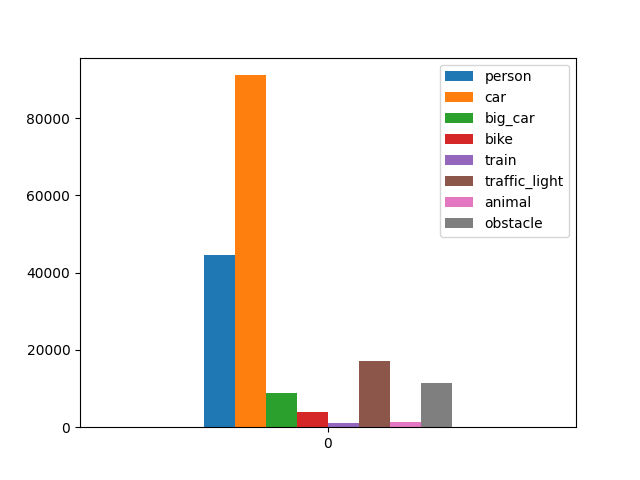

In [81]:
import matplotlib
matplotlib.style.use('default')
full_df.plot.bar(rot=0)

#### Validation

In [33]:
validation_stats = DatasetStats(bdd_validation_6000, kitti_validation_6000, coco_validation)

In [34]:
validation_stats.coco.value_counts()

labels       
person           7123
car              1217
chair            1084
dining table      429
traffic light     414
bench             281
truck             258
motorcycle        245
bicycle           224
bus               196
tv                173
couch             148
laptop            142
dog               141
cat               127
train             111
bed                98
fire hydrant       70
parking meter      35
dtype: int64

In [36]:
validation_stats.kitti.value_counts()

labels        
Car               5719
DontCare          2046
Van                528
Pedestrian         426
Cyclist            278
Truck              196
Misc               179
Tram                73
Person_sitting      19
dtype: int64

In [35]:
validation_stats.bdd.value_counts()

labels       
car              12265
traffic sign      4105
traffic light     3066
person            1743
truck              499
bus                174
bike               141
rider               98
motor               42
train                1
dtype: int64

### TFRecord blueprint as DataFrame

Map datasets default labels to expected labels:

        1 - person
        2 - car
        3 - big_car
        4 - bike
        5 - train
        6 - traffic_light
        7 - animal
        8 - obstacle


In [25]:
class DFHandler:
    def prepare_input(self, data, ids, filenames, bounding_boxes, labels):
        for bbox, label in zip(data['bboxes'], data['labels']):
            ids.append(data["id"])
            filenames.append(data['filename'])
            bounding_boxes.append(bbox)
            labels.append(label)

        return ids, filenames, bounding_boxes, labels

    def handle(self, dataset, ids, filenames, bounding_boxes, labels):
        for img in dataset:
            data = self.preprocess_data(img)
            ids, filenames, bounding_boxes, labels = self.prepare_input(data, ids, filenames, bounding_boxes, labels)

        return ids, filenames, bounding_boxes, labels




In [26]:
class COCOHandler(DFHandler):
    label_map = {
        "person": 1,
        "car": 2,
        "chair": 8,
        "dining table": 8,
        "traffic light": 6,
        "truck": 3,
        "bench": 8,
        "motorcycle": 4,
        "bicycle": 4,
        "dog": 7,
        "bus": 3,
        "couch": 8,
        "tv": 8,
        "laptop": 8,
        "train": 5,
        "cat": 7,
        "bed": 8,
        "fire hydrant": 8,
        "parking meter": 8,
    }

    def preprocess_data(self, data):
        labels = []
        bboxes = []
        for detection in data.ground_truth.detections:
            bboxes.append(detection.bounding_box)
            labels.append(self.label_map[detection.label])

        return {"id": f"{data['id']}_coco", 'filename': data["filepath"], "labels": labels, "bboxes":bboxes}

In [27]:
class BDDHandler(DFHandler):
    label_map = {
        'traffic light': 6,
        'car': 2,
        'person': 1,
        'motor': 4,
        'bus': 3,
        'truck': 3,
        'bike': 4,
        'train': 5,
    }

    def preprocess_data(self, data):
        labels = []
        bboxes = []
        for detection in data.detections.detections:
            if detection.label in self.label_map:
                bboxes.append(detection.bounding_box)
                labels.append(self.label_map[detection.label])

        return {"id": f"{data['id']}_bdd", 'filename': data["filepath"], "labels": labels, "bboxes":bboxes}

In [28]:
class KITTIHandler(DFHandler):
    label_map = {
        'Car': 2,
        'Van': 3,
        'Pedestrian': 1,
        'Truck': 3,
        'Cyclist': 4,
        'Tram': 5,
        'Person_sitting': 1
    }

    def preprocess_data(self, data):
        labels = []
        bboxes = []
        for detection in data.ground_truth.detections:
            if detection.label in self.label_map:
                bboxes.append(detection.bounding_box)
                labels.append(self.label_map[detection.label])

        return {"id": f"{data['id']}_kitti", 'filename': data["filepath"], "labels": labels, "bboxes":bboxes}

In [29]:
def create_pandas_blueprint(coco_ds, bdd_ds, kitti_ds):
    coco_handler = COCOHandler()
    bdd_handler = BDDHandler()
    kitti_handler = KITTIHandler()

    id, filename, boxes, labels = coco_handler.handle(coco_ds, [], [], [], [])
    id, filename, boxes, labels = bdd_handler.handle(bdd_ds, id, filename, boxes, labels)
    id, filename, boxes, labels = kitti_handler.handle(kitti_ds, id, filename, boxes, labels)

    return pd.DataFrame({"id": id,"filename": filename, "bboxes": boxes, "label": labels})

In [27]:
train_df = create_pandas_blueprint(coco_train, bdd_train_6000, kitti_train_6000)

In [28]:
validation_df = create_pandas_blueprint(coco_validation, bdd_validation_6000, kitti_validation_6000)

### Write TFRecords

In [43]:
class Sample:
    label_map = {
        1: "person".encode('utf8'),
        2: "car".encode('utf8'),
        3: "big_car".encode('utf8'),
        4: "bike".encode('utf8'),
        5: "train".encode('utf8'),
        6: "traffic_light".encode('utf8'),
        7: "animal".encode('utf8'),
        8: "obstacle".encode('utf8')
    }

    def __init__(self, data):
        self.filename = data['filename'].encode('utf8')
        self.source_id = self.filename

        self.encoded_image = self.get_encoded_image(data)
        
        height, width, format = self.get_image_data(data)
        self.height, self.width, self.format = height, width, format
        
        self.label = []
        self.text = []
        self.xmin, self.xmax, self.ymin, self.ymax = [], [], [], []

    def get_encoded_image(self, data):
        with tf.io.gfile.GFile(data['filename'], 'rb') as fid:
            encoded_jpg = fid.read()

            if encoded_jpg == b'': raise IOError('Corrupted file')
        return encoded_jpg

    def get_image_data(self, data):
        encoded_jpg_io = io.BytesIO(self.encoded_image)
        image = Image.open(encoded_jpg_io)

        # Check for corruption in jpg files
        try:
            image.getdata()[0]
        except:
            raise IOError("Corrupted file")

        width, height = image.size

        image_format = data['filename'][-3:].encode('utf8')

        return height, width, image_format

    def add_bounding_box(self, data):
        self.xmin.append(data['bboxes'][0])
        self.xmax.append(data['bboxes'][0] + data['bboxes'][2])
        self.ymin.append(data['bboxes'][1])
        self.ymax.append(data['bboxes'][1] + data['bboxes'][3])

    def add_label(self, data):
        self.label.append(data['label'])
        self.text.append(self.label_map[data['label']])

In [44]:
class TFRecordWriter:
  
    def __init__(self, dataset_df, path, type):
        self.df = dataset_df
        self.type = type
        self.path = path

    def write_record(self):
        ids = self.prepare_index()
        self.open_file()

        for id in ids:
            data = self.df.query(f'id == "{id}"')
            try:
                sample = Sample(data.iloc[0])

                for index, row in data.iterrows():
                    sample.add_bounding_box(row)
                    sample.add_label(row)

                tf_example = self.create_tf_example(sample)
                self.write_to_file(tf_example) 

            except IOError:
                pass
            
        self.close_file

    def prepare_index(self):
        ids = self.df["id"].unique()
        shuffle(ids)
        return ids

    def open_file(self):
        self.writer = tf.io.TFRecordWriter(rf"{self.path}/{self.type}.records")

    def write_to_file(self, tf_example):
        self.writer.write(tf_example.SerializeToString()) 

    def close_file(self):
        self.writer.close()

    def create_tf_example(self, sample):

        tf_example = tf.train.Example(features=tf.train.Features(feature={
            'image/height': dataset_util.int64_feature(sample.height),
            'image/width': dataset_util.int64_feature(sample.width),
            'image/filename': dataset_util.bytes_feature(sample.filename),
            'image/source_id': dataset_util.bytes_feature(sample.source_id),
            'image/encoded': dataset_util.bytes_feature(sample.encoded_image),
            'image/format': dataset_util.bytes_feature(sample.format),
            'image/object/bbox/xmin': dataset_util.float_list_feature(sample.xmin),
            'image/object/bbox/xmax': dataset_util.float_list_feature(sample.xmax),
            'image/object/bbox/ymin': dataset_util.float_list_feature(sample.ymin),
            'image/object/bbox/ymax': dataset_util.float_list_feature(sample.ymax),
            'image/object/class/text': dataset_util.bytes_list_feature(sample.text),
            'image/object/class/label': dataset_util.int64_list_feature(sample.label),
        }))
        return tf_example


In [45]:
train_record_writer = TFRecordWriter(train_df, r"prepared_datasets", "train")
train_record_writer.write_record()

In [46]:
validation_record_writer = TFRecordWriter(validation_df, r"prepared_datasets", "validation")
validation_record_writer.write_record()